## Train modified LeNet CNN on CIFAR-10

Development version of the CNN training code. The last cells contain code for plotting the accuracies after network reduction by pruning duplicates..


In [1]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import json
from vis_utils import *
from model_def import *
from model_train import *
%matplotlib inline

# specify experiment settings
expName = 'cifar-lenet-v1_w1-100'
batchSize = 100
useGpu = True
numEpochs = 30
learningRate = 0.01
momentum = 0.9
weight_decay = 5e-3

gamma = 0.1
w1 = 100
w2 = 50
# -----------------------------------------------------------------------------


# create experiment folder
expDir = os.path.join('./data', expName)
if not os.path.exists(expDir):
    os.makedirs(expDir)
    
# save training config 
# (NOTE: changing values in the JSON will not reflect in training)
cfg = {'useGpu': useGpu, 'numEpochs': numEpochs, \
       'learningRate': learningRate, \
       'batchSize': batchSize, 'momentum': momentum, \
       'weight_decay': weight_decay, \
       'gamma': gamma, 'w1': w1, 'w2': w2}

# cfg = json.load(file(os.path.join(expDir,'train_config.json'), 'r'))
with open(os.path.join(expDir,'train_config.json'), 'w') as config_file :
    json.dump(cfg, config_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

In [20]:
# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data(batchSize)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
# create ConvNet
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
print(net)

NetWide (
  (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(100, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (1250 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [24]:
# Define a Loss function and optimizer settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learningRate, \
                      momentum=momentum, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=gamma)

In [25]:
if not os.path.isfile(os.path.join(expDir, 'net-trained.dat')):
    # Train the network
    train_cifar_net(net, trainloader, testloader, \
                    criterion, (optimizer,lr_scheduler), expDir, \
                    batchSize=batchSize,
                    numEpochs=numEpochs, useGpu=useGpu, \
                    doVisFilter=False, \
                    fixFilterList=[], verboseFrequency=100)

    torch.save(net.state_dict(), os.path.join(expDir,'net-trained.dat'))
else:
    print 'Loading network state dict from file.'
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    print 'Done.'


Loading network state dict from file.
Done.


In [26]:
# Evaluate

if useGpu:
    net.cuda()

# Performance on train set
train_acc = accuracy_on_dataset(net, trainloader, useGpu)
print('Accuracy of the network on the 50000 training images: %d %%' % (
    train_acc))

# Performance on test set
test_acc = accuracy_on_dataset(net, testloader, useGpu)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    test_acc))

# Per-class accuracy on test set
print_cifar_per_class_accuracy(net, classes, testloader, useGpu)


res = {'train_acc': train_acc, 'test_acc': test_acc}

# cfg = json.load(file(os.path.join(expDir,'train_config.json'), 'r'))
with open(os.path.join(expDir,'model_acc.json'), 'w') as res_file :
    json.dump(res, res_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

Accuracy of the network on the 50000 training images: 85 %
Accuracy of the network on the 10000 test images: 76 %
Accuracy of plane : 88 %
Accuracy of   car : 87 %
Accuracy of  bird : 65 %
Accuracy of   cat : 62 %
Accuracy of  deer : 71 %
Accuracy of   dog : 56 %
Accuracy of  frog : 81 %
Accuracy of horse : 87 %
Accuracy of  ship : 87 %
Accuracy of truck : 86 %


### Visualize the conv-1 filters



In [27]:
# transfer network to CPU if on GPU
if next(net.parameters()).is_cuda:
    net.cpu()

# get layer parameters by name
param_dict = net.state_dict()
w_conv1 = param_dict['conv1.weight']
w_conv1 = w_conv1.numpy()

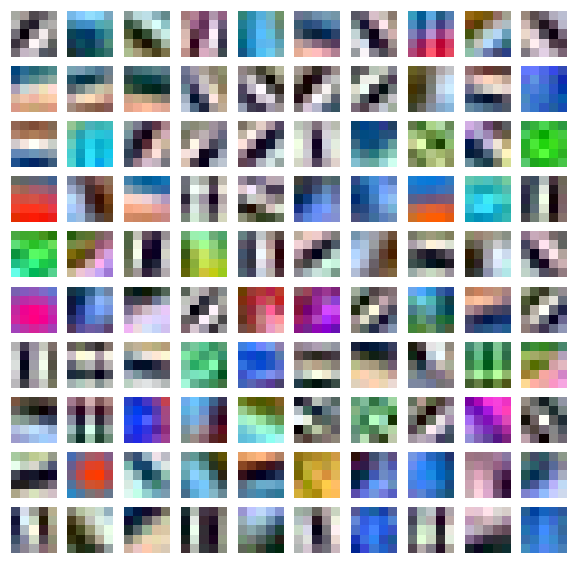

In [28]:
%matplotlib inline

f = vis_kernels(w_conv1, num_cols=10) # input must be a Kx3xWxH tensor.
f.savefig(os.path.join(expDir,'lenet-filter.png'), 
                        bbox_inches='tight')


In [29]:
net.cpu()
similMat, w = get_layer_cosine_similarity(net, 'conv1.weight') # returned as numpy arrays
np.save(os.path.join(expDir,'simil-mat'), similMat)
np.save(os.path.join(expDir,'w-mat'), w)
smat = np.load(os.path.join(expDir,'simil-mat.npy'))
w_mat = np.load(os.path.join(expDir,'w-mat.npy'))

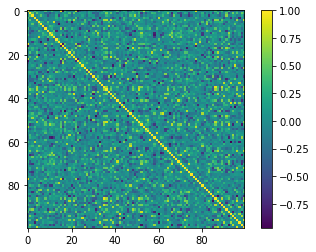

In [30]:
f = plt.figure()
plt.imshow(similMat)
plt.colorbar()
f.savefig(os.path.join(expDir,'lenet-simil-mat.png'), 
                        bbox_inches='tight')

## Filter groups

In [31]:
# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))


In [32]:
net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)

Original network data loss: 0.6871


In [15]:
# Settings
%matplotlib inline
SIMIL_THRESH = 0.9
LAYER_CURR = 'conv1'
LAYER_NEXT = 'conv2'

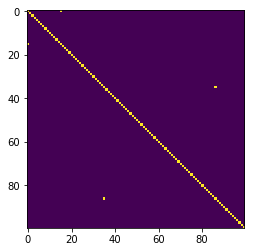

In [33]:
# Get an adjancency matrix by thresholding the similarity matrix
net.cpu()
similMat, _ = get_layer_cosine_similarity(net, LAYER_CURR+'.weight') # returned as numpy arrays
np.save(os.path.join(expDir,'simil-mat'), similMat)
sz = similMat.shape
adj_mat = np.greater(similMat, SIMIL_THRESH)

f = plt.figure()
plt.imshow(adj_mat)  # show adjacency matrix
plt.savefig(os.path.join(expDir,'lenet-w1-adj-mat-%.2f.png' % SIMIL_THRESH), bbox_inches='tight')

In [34]:
# Find connected components in the graph induced by the adjacency matrix
cc_list, n_comps = get_adjmat_conn_comp(adj_mat)
print 'Number of connected comps in graph: %d ' % n_comps


Number of connected comps in graph: 98 


In [35]:
def get_param(net, param_name):
    params = net.state_dict()
    w = params[param_name]
    return w

In [36]:
# Get network parameters
net.cpu()
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
layer_curr_biases = get_param(net, LAYER_CURR+'.bias')
layer_next_weights = get_param(net, LAYER_NEXT+'.weight')


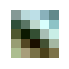

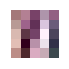

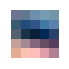

In [37]:
# Some sanity-checks: visualize some of the filter groups
f = vis_kernels(layer_curr_weights.numpy()[cc_list[2]]) 
f = vis_kernels(layer_curr_weights.numpy()[cc_list[3]]) 
f = vis_kernels(layer_curr_weights.numpy()[cc_list[5]])

KeyboardInterrupt: 

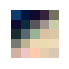

In [38]:
# Plot the filters in each filter group and save the figures to file
outDir = os.path.join(expDir, ('filter_ccomp_%.2f' % SIMIL_THRESH))
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
for i in range(len(cc_list)):
        
    f = vis_kernels(layer_curr_weights.numpy()[cc_list[i]]) 
     
    f.savefig(os.path.join(outDir, ('%d.png' % i)), \
             bbox_inches='tight')
    plt.close(f)
    
plt.rcParams.update(plt.rcParamsDefault)

## Network reduction

Reducing a network by eliminating near-duplicate filters consists of the following steps, after having formed groups of similar filters:

1. down-scale the filters of the current layer to have unit norm, and correspondingly up-scale the next layer filters.
2. collapse filter groups


### Scale filters

In [39]:
# Parameter scaling - should work for both Linear and Conv

# Scale the conv1 filter weights and the biases by the inverse of the filter norms
w_n = [torch.norm(w.view(-1),p=2) for w in layer_curr_weights] # 2-norm of flattened cxhxw kernels
w_normed = [w.div(w_n[index]) for index, w in enumerate(layer_curr_weights)] # normalize
w_normed = torch.stack(w_normed, dim=0)
b_normed = torch.FloatTensor([b/w_n[index] for index, b in enumerate(layer_curr_biases)])


In [40]:
# Sanity-checks: norms should be near 1
print torch.norm(w_normed[0],p=2)
print torch.norm(w_normed[1],p=2)
print layer_next_weights.size() # (outChannels x inChannels x h x w)
print layer_next_weights[:,1].size() # (outChannels x h x w) slice

1.00000001346
1.00000000149
torch.Size([50, 100, 5, 5])
torch.Size([50, 5, 5])


In [41]:
# Scale the next layer weights by the current layer's filter norms
layer_next_scaled = [] 
for i in range(layer_next_weights.size()[1]):
    layer_next_scaled.append( layer_next_weights[:,i] * w_n[i] )
layer_next_scaled = torch.stack(layer_next_scaled, dim=1)

In [42]:
# Sanity-check: should match layer_next_weights.size()
print layer_next_scaled.size() 

torch.Size([50, 100, 5, 5])


In [43]:
# Update the parameters of the network
param_dict = net.state_dict()
param_dict[LAYER_CURR+'.weight'] = w_normed
param_dict[LAYER_CURR+'.bias'] = b_normed
param_dict[LAYER_NEXT+'.weight'] = layer_next_scaled
net.load_state_dict(param_dict)

In [44]:
# Run the modified network
net.cuda()
new_data_loss = get_dataset_loss(net, testloader)

new_data_loss = np.asarray(new_data_loss)
orig_data_loss = np.asarray(orig_data_loss)

print 'Orig mean data loss: %f' % np.mean(orig_data_loss)
print 'Modified mean data loss: %f' % np.mean(new_data_loss)

Orig mean data loss: 0.687090
Modified mean data loss: 0.687090


### Reduce similar filters


In [45]:
# Check the network accuracy
net.eval()
net.cuda()
orig_accu = accuracy_on_dataset(net, testloader, True)
print 'Network accuracy: %.2f%%' % orig_accu

Network accuracy: 76.00%


In [20]:
# transfer network to CPU if on GPU
if next(net.parameters()).is_cuda:
    net.cpu()
    
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
layer_curr_biases = get_param(net, LAYER_CURR+'.bias')
layer_next_weights = get_param(net, LAYER_NEXT+'.weight')

In [21]:
# Reduce current layer filters - mean
layer_curr_filter_groups = [layer_curr_weights[torch.LongTensor(x)] for x in cc_list]
layer_curr_filter_reduced = [x.mean(dim=0) for x in layer_curr_filter_groups]
layer_curr_filter_cat = torch.stack(layer_curr_filter_reduced, dim=0)
print layer_curr_filter_cat.size()

torch.Size([239, 3, 5, 5])


In [22]:
# Reduce FC-1 layer biases - mean
layer_curr_bias_groups = [layer_curr_biases[torch.LongTensor(x)] for x in cc_list]
layer_curr_bias_reduced = [x.mean() for x in layer_curr_bias_groups]
layer_curr_bias_cat = torch.FloatTensor(layer_curr_bias_reduced)
print layer_curr_bias_cat.size()

torch.Size([239])


In [23]:
# Reduce FC-2 layer weights - sum
layer_next_groups = [layer_next_weights[:,x] for x in cc_list]
layer_next_reduced = [x.sum(dim=1) for x in layer_next_groups]
layer_next_cat = torch.stack(layer_next_reduced, dim=1)
print layer_next_cat.size()

torch.Size([50, 239, 5, 5])


In [24]:
# Update the parameters of the network
#  - HACK: PyTorch does not allow loading a state_dict when sizes change
params = net.named_parameters() # generator
s = set([LAYER_CURR+'.weight', \
         LAYER_CURR+'.bias', \
         LAYER_NEXT+'.weight'])
param_dict = {y[0]: y[1] for y in filter(lambda x: x[0] in s, params)}

param_dict[LAYER_CURR+'.weight'].data = layer_curr_filter_cat
param_dict[LAYER_CURR+'.bias'].data = layer_curr_bias_cat
param_dict[LAYER_NEXT+'.weight'].data = layer_next_cat

In [25]:
# Sanity check: verify that the network's param sizes have changed
print net.conv1.weight.size()
print net.conv1.bias.size()
print net.conv2.weight.size()

torch.Size([239, 3, 5, 5])
torch.Size([239])
torch.Size([50, 239, 5, 5])


In [26]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu

Reduced network accuracy: 69.00 %


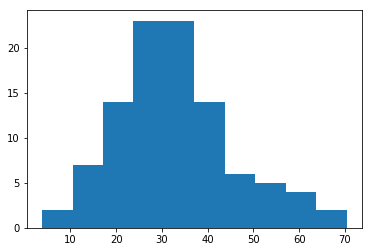

In [27]:
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);

In [42]:
net.cpu()
w = get_param(net, LAYER_CURR+'.weight').numpy()

# Group the filters in each connected component (cc)
outDir = os.path.join(expDir, ('filter_ccomp_%.2f' % SIMIL_THRESH))
if not os.path.exists(outDir):
    os.makedirs(outDir)

### Baseline: low L1 norm

In [158]:
NUM_KEEP = 239 

# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

# get parameters
net.cpu()
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
layer_curr_biases = get_param(net, LAYER_CURR+'.bias')
layer_next_weights = get_param(net, LAYER_NEXT+'.weight')


In [29]:
w_norms = [torch.norm(w.view(-1), p=1) for w in layer_curr_weights]
sort_indices = np.argsort(w_norms)
w_norms = np.asarray(w_norms)
pruned_indices = sort_indices[-NUM_KEEP:]

In [30]:
# current layer filter reduction
layer_curr_filter_reduced = layer_curr_weights[torch.LongTensor(pruned_indices)]
layer_curr_bias_reduced = layer_curr_biases[torch.LongTensor(pruned_indices)]
layer_next_reduced = layer_next_weights[:,torch.LongTensor(pruned_indices)]

In [31]:
print layer_curr_filter_reduced.size()
print layer_curr_bias_reduced.size()
print layer_next_reduced.size() 

torch.Size([239, 3, 5, 5])
torch.Size([239])
torch.Size([50, 239, 5, 5])


In [35]:
# Update the parameters of the network
#  - HACK: PyTorch does not allow loading a state_dict when sizes change
params = net.named_parameters() # generator
s = set([LAYER_CURR+'.weight', \
         LAYER_CURR+'.bias', \
         LAYER_NEXT+'.weight'])
param_dict = {y[0]: y[1] for y in filter(lambda x: x[0] in s, params)}

param_dict[LAYER_CURR+'.weight'].data = layer_curr_filter_reduced
param_dict[LAYER_CURR+'.bias'].data = layer_curr_bias_reduced
param_dict[LAYER_NEXT+'.weight'].data = layer_next_reduced

In [36]:
# Evaluate baseline network's accuracy
net.cuda()
net.eval()
baseline_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % baseline_accu

Reduced network accuracy: 70.00 %


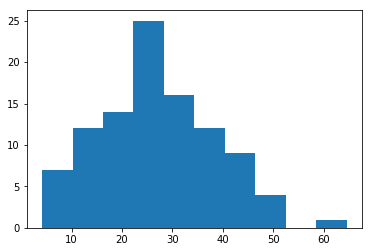

In [37]:
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);

## Accuracy plots

In [9]:
def plot_acc_fig(compression, acc_dup, acc_norm, num_filter):
    f = plt.figure()
    plt.plot(compression, acc_dup, 'o-', label='dup')
    plt.plot(compression, acc_norm, 'o-', label='norm')
    plt.xlabel('Compression (%)')
    plt.xticks(compression)
    plt.ylabel('Test accuracy (%)')
    plt.title('Conv1: %d' % num_filter)
    plt.legend(loc="lower left")
    return f

In [8]:
outDir = 'data/figures/cnn-cifar'
plt.rcParams.update({'font.size': 20})

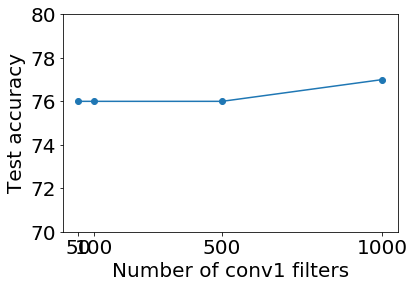

In [10]:
num_filter = [50, 100, 500, 1000]
acc_orig = [76, 76, 76, 77]

# plt.rcParams.update(plt.rcParamsDefault)
f = plt.figure()
plt.plot(num_filter, acc_orig, 'o-')
plt.ylim(70,80)
plt.xlabel('Number of conv1 filters')
plt.xticks(num_filter)
plt.ylabel('Test accuracy')
f.savefig(os.path.join(outDir,'lenet-accuracy-filters.png'), bbox_inches='tight')
f.savefig(os.path.join(outDir,'lenet-accuracy-filters.pdf'), bbox_inches='tight')

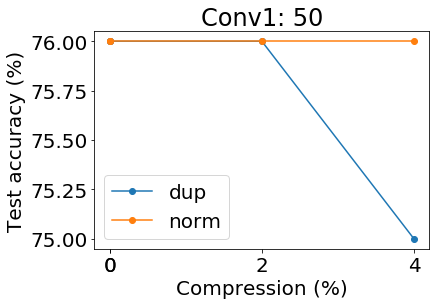

In [11]:
# w1: 50
num_w1 = 50.0
thresh = [1, 0.9, 0.85, 0.8]
acc_dup = [76, 76, 76, 75]
acc_norm = [76, 76, 76, 76]
num_filters = [50, 50, 49, 48]
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

# plt.rcParams.update(plt.rcParamsDefault)
f = plot_acc_fig(compression, acc_dup, acc_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-50-pruning.png'), bbox_inches='tight')


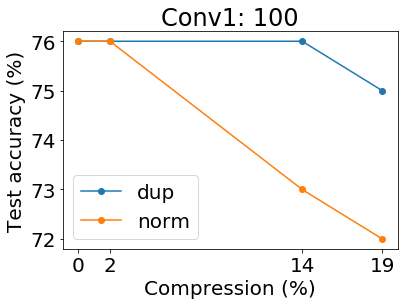

In [12]:
# w1: 100
num_w1 = 100.0
thresh = [1, 0.9, 0.85, 0.8]

acc_dup = [76, 76, 76, 75]
acc_norm = [76, 76, 73, 72]
num_filters = [100, 98, 86, 81]
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

# plt.rcParams.update(plt.rcParamsDefault)
f = plot_acc_fig(compression, acc_dup, acc_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-100-pruning.png'), bbox_inches='tight')

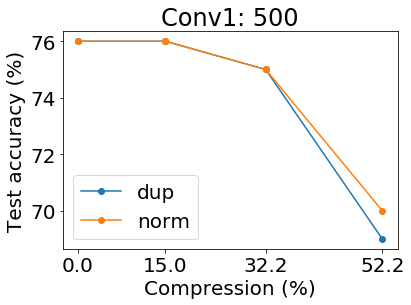

In [13]:
# w1: 500
num_w1 = 500.0
thresh = [1, 0.9, 0.85, 0.8]
acc_dup = [76, 76, 75, 69]
acc_norm = [76, 76, 75, 70]
num_filters = [500, 425, 339, 239]
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

# plt.rcParams.update(plt.rcParamsDefault)
f = plot_acc_fig(compression, acc_dup, acc_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-500-pruning.png'), bbox_inches='tight')

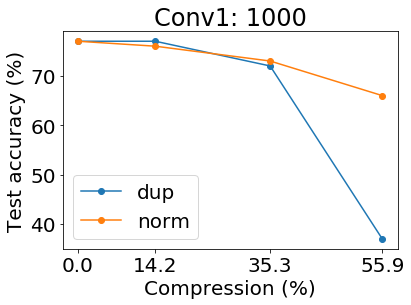

In [14]:
# w1: 1000
num_w1 = 1000.0
thresh = [1, 0.9, 0.85, 0.8]
acc_dup = [77, 77, 72, 37]
acc_norm = [77, 76, 73, 66]
num_filters = np.asarray([1000, 858, 647, 441])
compression = (num_w1 - np.asarray(num_filters))/num_w1 * 100

# plt.rcParams.update(plt.rcParamsDefault)
f = plot_acc_fig(compression, acc_dup, acc_norm, num_w1);
f.savefig(os.path.join(outDir,'lenet-w1-1000-pruning.png'), bbox_inches='tight')


